### 1. PyTorch basics

План на сегодня: знакомство с PyTorch

1. Тензоры и операции над ними
2. Граф вычислений и автоматическое дифференцирование
3. Реализация новых операций с помощью `torch.autograd.Function`
4. Перцептрон на pytorch

In [1]:
import torch

print(torch.__version__)
print(f"CUDA available: {torch.cuda.is_available()}")

2.4.0
CUDA available: False


#### 1.1. Тензоры, способы создания и атрибуты

Всё очень похоже на `numpy`

https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html

Основные атрибуты: ранг (`dim`), размерности (`shape`), тип значений (`type`), место размещения (`device`)

In [2]:
# из списка
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
# посмотрим сам тензор и его атрибуты
print(x)
print(
    "\nRank: ",
    x.dim(),
    "\nShape: ",
    x.shape,
    "\nDevice: ",
    x.device,
    "\ntype: ",
    x.type(),
)

tensor([[1, 2, 3],
        [4, 5, 6]])

Rank:  2 
Shape:  torch.Size([2, 3]) 
Device:  cpu 
type:  torch.LongTensor


In [3]:
# примеры: сложение, умножение на скаляр, агрегация, матричное умножение
y = torch.tensor([[1, -2, 3], [-4, 5, -6]]).float()
print(x + y)
print(0.5 * x)
print(y.mean(dim=0))
print(x.float() @ y.T)

tensor([[ 2.,  0.,  6.],
        [ 0., 10.,  0.]])
tensor([[0.5000, 1.0000, 1.5000],
        [2.0000, 2.5000, 3.0000]])
tensor([-1.5000,  1.5000, -1.5000])
tensor([[  6., -12.],
        [ 12., -27.]])


#### 1.2. Broadcasting

https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html#in-brief-tensor-broadcasting

Некоторые операции поддерживают `broadcast`, то есть размерности аргументов автоматически расширяются до нужного размера без копирования данных

Общие правила, когда это работает:
1. Все тензоры не пустые
2. При сравнении размеров тензоров, начиная с последней:
   1. Размерности совпадают, или
   2. Одна из размерностей равна $1$, или
   3. Размерность отсутствует в одном из тензоров


Благодаря `broadcast` многие вещи получается описать лаконично.

Возможно ли сложить тензоры `x` и `y` в примерах снизу?

In [4]:
# x=torch.empty(5,7,3)
# y=torch.empty(5,7,3)

# x=torch.empty((0,))
# y=torch.empty(2,2)

# x=torch.empty(5,3,4,1)
# y=torch.empty(  3,1,1)

# x=torch.empty(5,2,4,1)
# y=torch.empty(  3,1,1)

# (x + y).shape

Пример: посчитаем матрицу попарных разностей между элементами пары векторов

In [5]:
x = torch.arange(6)
y = torch.arange(4)
print(x)
print(y)
# преобразуем форму x к (6, 1) и попробуем вычесть y
x.view(-1, 1) - y
# формы тензоров x: (6, 1), y: (4,), последняя размерность в x равна 1,
# а следующая отсутствует в y, значит работает broadcast

tensor([0, 1, 2, 3, 4, 5])
tensor([0, 1, 2, 3])


tensor([[ 0, -1, -2, -3],
        [ 1,  0, -1, -2],
        [ 2,  1,  0, -1],
        [ 3,  2,  1,  0],
        [ 4,  3,  2,  1],
        [ 5,  4,  3,  2]])

### 2. Autograd в PyTorch

https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

#### 2.1. Вычислительный граф и дифференцирование

`autograd` строит DAG (directed acyclic graph) из объектов `torch.autograd.Function`, листья - входные тензоры, корни - выходные тензоры. Проход по графу позволяет рассчитать градиенты по правилу производной сложной функции (chain rule).

Прямой проход:
- расчёт значения выходного тензора
- построение графа и сохранение нужных для обратного прохода данных для каждой операции

Обратный проход (вызов `.backward()` у корня графа):
- расчёт градиентов и их накопление в артибуте `.grad` каждого тензора
- распространение вычислений далее до листьев графа

Рассмотрим выражение $f(x, y) = x^2 + xy + (x + y)^2$ и построим его граф:

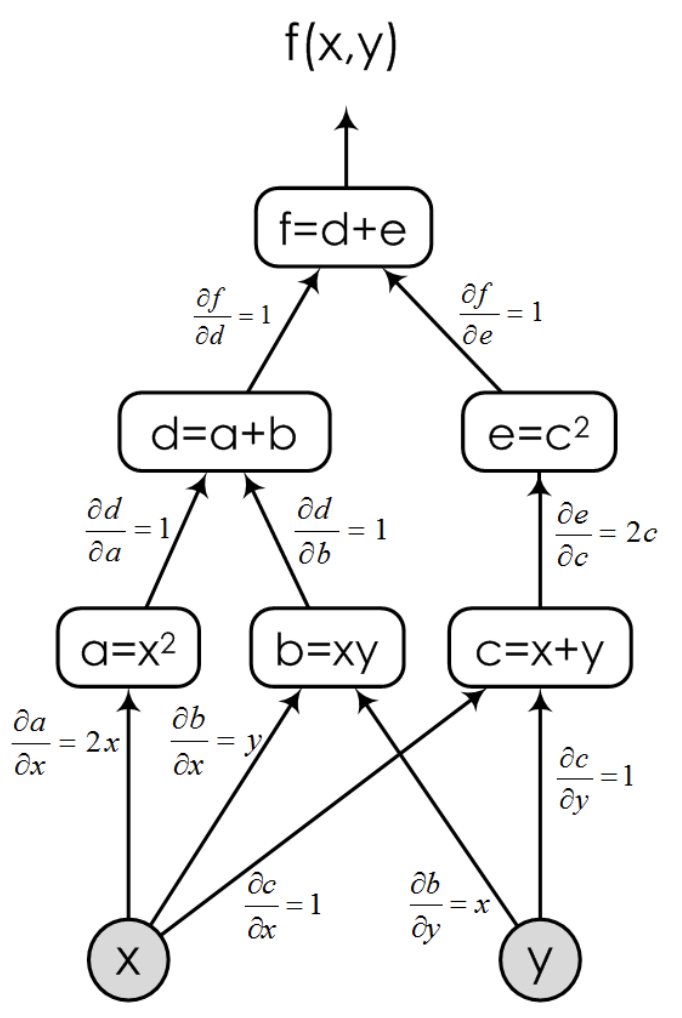

Запишем выражение для $f(x, y)$, задав начальные условия $x = 2.0, y = 2.0$.

In [6]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
a = x**2
b = x * y
c = x + y
d = a + b
e = c**2
f = d + e
f

tensor(24., grad_fn=<AddBackward0>)

`grad_fn` означает, что `f` не просто отдельный тензор, а связан с вычислительным графом и соответствует операции `Add`

Запустим backprop и убедимся, что градиенты рассчитаны правильно:

$\frac{\partial f}{\partial x} = 2x + y + 2(x + y)$

$\frac{\partial f}{\partial y} = x + 2(x + y)$

In [7]:
f.backward()
print(x.grad)
print(y.grad)

tensor(14.)
tensor(10.)


Повторный вызов `backward()` приведёт к ошибке, потому что после предыдущего вызова граф уже уничтожен для высвобождения ресурсов. Такое поведение по умолчанию оправдано, но если мы по какой-то причине хотим сохранить граф, следует указать `.backward(retain_graph=True)`

In [8]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
a = x**2
b = x * y
c = x + y
d = a + b
e = c**2
f = d + e

# вызовем backward дважды и посмотрим на градиенты:
print("Первый вызов")
f.backward(retain_graph=True)
print("Производная по x: ", x.grad)
print("Производная по x: ", y.grad)

print("\nВторой вызов")
f.backward(retain_graph=True)
print("Производная по x: ", x.grad)
print("Производная по x: ", y.grad)

Первый вызов
Производная по x:  tensor(14.)
Производная по x:  tensor(10.)

Второй вызов
Производная по x:  tensor(28.)
Производная по x:  tensor(20.)


После второго вызова градиенты удвоились, но здесь нет ошибки: градиенты накапливаются в поле `.grad`, и если мы хотим избавиться от истории прошлых вычислений, это стоит сделать явно

In [9]:
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
a = x**2
b = x * y
c = x + y
d = a + b
e = c**2
f = d + e

# вызовем backward дважды и посмотрим на градиенты:
print("Первый вызов")
f.backward(retain_graph=True)
print("Производная по x: ", x.grad)
print("Производная по x: ", y.grad)
# обнулим градиенты, можно сделать двумя способами
x.grad = None
y.grad = torch.tensor(0.0)

print("\nВторой вызов")
f.backward(retain_graph=True)
print("Производная по x: ", x.grad)
print("Производная по x: ", y.grad)

Первый вызов
Производная по x:  tensor(14.)
Производная по x:  tensor(10.)

Второй вызов
Производная по x:  tensor(14.)
Производная по x:  tensor(10.)


Иногда мы можем захотеть посмотреть на градиенты не только в листовых вершинах графа, но и во внутренних. По умолчанию Pytorch эти данные не сохраняет:

In [10]:
x = torch.tensor(1.0, requires_grad=True)
y = x + 1
z = y**2
z.backward()
y.grad

/var/folders/z3/n11m8hqx40s1trg9fk01s2qh0000gp/T/ipykernel_20182/541772334.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538195853/work/build/aten/src/ATen/core/TensorBody.h:494.)
  y.grad


Но если очень нужно, то мы можем пометить любой тензор, где хочется узнать значение производной, вызвав метод `.retain_grad()`

In [11]:
x = torch.tensor(1.0, requires_grad=True)
y = x + 1
# помечаем y
y.retain_grad()
z = y**2
z.backward(retain_graph=True)
y.grad

tensor(4.)

#### 2.2. Отключение расчёта градиентов

https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc

Иногда мы хотим локально отключить расчёт градиентов: это может пригодится, когда мы хотим изменить значения каких-то параметров и не сломать при этом вычислительный граф (о том, что может происходить, если в нужном месте не отключить трекинг градиентов, см ниже в разделе $3.3$)

Несколько способов:
1. Изменить значение атрибута тензора `requires_grad` напрямую

In [12]:
x = torch.tensor(1.0, requires_grad=True)
y = x + 1
print(y.requires_grad)  # True
x.requires_grad = False
y = x + 1
print(y.requires_grad)  # False

True
False


2. Использовать `torch.no_grad()` (как менеджер контекста или как декоратор)

In [13]:
x = torch.tensor(1.0, requires_grad=True)
y = x + 1
print(x.requires_grad)  # True

# локально отключаем трекинг градиентов
with torch.no_grad():
    y = x + 1
print(y.requires_grad)  # False

True
False


In [14]:
# декоратор
def add_one(t: torch.Tensor) -> torch.Tensor:
    return t + 1


@torch.no_grad()
def add_two(t: torch.Tensor) -> torch.Tensor:
    return t + 1


x = torch.tensor(1.0, requires_grad=True)
y = add_one(x)
print(y.requires_grad)  # True
z = add_two(x)
print(z.requires_grad)  # False

True
False


3. Получить копию тензора с помощью метода `.detach()`

In [15]:
x = torch.tensor(1.0, requires_grad=True)
y = x + 1
print(x.requires_grad)  # True
z = y.detach()
print(z.requires_grad)  # False

True
False


#### 2.3 Некоторые распространённые ошибки

1. Обновление параметра на месте вне контекста `torch.no_grad()` вызовет ошибку. PyTorch такое явно запрещает

In [16]:
w = torch.tensor(1.0, requires_grad=True)
# x = torch.tensor(1.0)
f = w + 1
f.backward()
w -= w.grad

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

2. Обновление параметра через присваивание приводит к тому, что параметр больше не является листом графа, в графе образовался цикл, и следующая итерация приведёт к ошибке:

In [17]:
w = torch.tensor(1.0, requires_grad=True)
# x = torch.tensor(1.0)
f = w + 1
# первая итерация - всё как будто ок
f.backward()
w = w - w.grad  # на этом моменте `w` - больше не лист графа
f = w + 1

# вторая итерация - оказывается, что не ок
f.backward()
w = w - w.grad  # здесь w.grad is None!

/var/folders/z3/n11m8hqx40s1trg9fk01s2qh0000gp/T/ipykernel_20182/963600647.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538195853/work/build/aten/src/ATen/core/TensorBody.h:494.)
  w = w - w.grad  # здесь w.grad is None!


TypeError: unsupported operand type(s) for -: 'Tensor' and 'NoneType'

3. Внутри контекста `torch.no_grad()` параметр обновляем не на месте, а через переназначение, после этого он более не ожидает градиентов, всё ломается при вызове `.backward()`

In [18]:
w = torch.tensor(1.0, requires_grad=True)
f = w + 1
# первая итерация
f.backward()
with torch.no_grad():
    w = w - w.grad  # упс, для w теперь requires_grad = False!
f = w + 1

# вторая итерация
f.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

#### 2.4. Класс `torch.autograd.Function`

Когда может пригодиться:
1. Добавление недифференцируемых вычислений
2. Добавление операций, реализованный вне PyTorch (NumPy, SciPy, etc.)
3. Более эффективное использование ресурсов (комбинирование операций, обёртка над реализацией на `C++`)

In [19]:
class MulConstant(torch.autograd.Function):
    @staticmethod
    def forward(tensor, constant):
        return tensor * constant

    @staticmethod
    def setup_context(ctx, inputs, output):
        # ctx is a context object that can be used to stash information
        # for backward computation
        tensor, constant = inputs
        ctx.constant = constant

    @staticmethod
    def backward(ctx, grad_output):
        # We return as many input gradients as there were arguments.
        # Gradients of non-Tensor arguments to forward must be None.
        return grad_output * ctx.constant, None

In [20]:
class Mul(torch.autograd.Function):
    @staticmethod
    def forward(tensor1, tensor2):
        return tensor1 * tensor2

    @staticmethod
    def setup_context(ctx, inputs, output):
        # ctx is a context object that can be used to stash information
        # for backward computation
        ctx.first, ctx.second = inputs

    @staticmethod
    def backward(ctx, grad_output):
        # We return as many input gradients as there were arguments.
        # Gradients of non-Tensor arguments to forward must be None.
        return ctx.second * grad_output, ctx.first * grad_output

In [21]:
x = torch.tensor(2.0, requires_grad=True)
mul_const = MulConstant.apply
res = mul_const(x, 4)
print("Result: ", res)
res.backward()
print("Gradient for x: ", x.grad)

Result:  tensor(8., grad_fn=<MulConstantBackward>)
Gradient for x:  tensor(4.)


In [22]:
mul = Mul.apply
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

res = mul(x, y)
print("Result: ", res)
res.backward()
print("Gradient for x: ", x.grad)
print("Gradient for y: ", y.grad)

Result:  tensor(6., grad_fn=<MulBackward>)
Gradient for x:  tensor(3.)
Gradient for y:  tensor(2.)


#### 3. Перцептрон: логистическая регрессия

$\hat{y} = \sigma(w^T x + b)$

$\sigma(t) = \frac{1}{1 + \exp(-t)}$

$\text{CE}(y, \hat{y}) = -y \cdot \log \hat{y} - (1 - y) \log (1 - \hat{y})$

<img src="https://pytorch.org/tutorials/_images/comp-graph.png" style="background:white" width="700"/>

##### 3.1. Наш первый цикл обучения

In [23]:
torch.manual_seed(42)
n_samples = 16
n_features = 5
x = torch.randn(n_samples, n_features)  # входной тензор
y = torch.randint(2, size=(n_samples, 1)).float()  # выходной тензор
w = torch.randn(
    n_features, 1, requires_grad=True
)  # параметр, хотим обновлять градиентным спуском
b = torch.randn(1, requires_grad=True)  # параметр, хотим обновлять градиентным спуском
z = torch.matmul(x, w) + b
y_hat = torch.sigmoid(z)
loss = (-y * y_hat.log() - (1 - y) * (1 - y_hat).log()).mean()
# loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)  # функция потерь, хотим минимизировать
loss

tensor(0.8950, grad_fn=<MeanBackward0>)

In [24]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x129bfbe20>
Gradient function for loss = <MeanBackward0 object at 0x129bfb4c0>


Напишем цикл для поиска параметров, минимизирующих функцию ошибки

In [25]:
n_iter = 1000
step = 0.1
for i in range(n_iter):
    z = x @ w + b
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
    # посчитаем производные
    loss.backward()

    # обновим значения параметров внутри менеджера контекста `no_grad`
    with torch.no_grad():
        w -= w.grad * step
        b -= b.grad * step

    # обнулим градиенты, мы не хотим их накапливать в данном случае
    w.grad = None
    b.grad = None

# посмотрим, уменьшилось ли значение ошибки
print(loss)

tensor(0.3861, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


#### 3.2. Добавляем оптимизатор

In [26]:
torch.manual_seed(42)
n_samples = 16
n_features = 5
x = torch.randn(n_samples, n_features)  # входной тензор
y = torch.randint(2, size=(n_samples, 1)).float()  # выходной тензор
w = torch.randn(
    n_features, 1, requires_grad=True
)  # параметр, хотим обновлять градиентным спуском
b = torch.randn(1, requires_grad=True)  # параметр, хотим обновлять градиентным спуском

In [27]:
optimizer = torch.optim.SGD([w, b], lr=0.1)

In [28]:
n_iter = 1000
step = 0.1
for i in range(n_iter):
    z = x @ w + b
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
    # посчитаем производные
    loss.backward()
    # обновим значения параметров
    optimizer.step()
    # обнулим градиенты, мы не хотим их накапливать в данном случае
    optimizer.zero_grad()

# посмотрим, уменьшилось ли значение ошибки
print(loss)

tensor(0.3861, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


### 3.3. Прячем параметры модели внутрь `torch.nn.Module`

In [29]:
class LogReg(torch.nn.Module):
    def __init__(self, in_features: int, n_classes: int) -> None:
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(in_features, n_classes))
        self.bias = torch.nn.Parameter(torch.randn(n_classes))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight + self.bias

In [30]:
torch.manual_seed(42)
n_samples = 16
n_features = 5
x = torch.randn(n_samples, n_features)  # входной тензор
y = torch.randint(2, size=(n_samples, 1)).float()  # выходной тензор

logreg = LogReg(n_features, 1)
optimizer = torch.optim.SGD(logreg.parameters(), lr=0.1)

In [31]:
n_iter = 1000
step = 0.1
for i in range(n_iter):
    z = logreg.forward(x)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
    # посчитаем производные
    loss.backward()
    # обновим значения параметров
    optimizer.step()
    # обнулим градиенты, мы не хотим их накапливать в данном случае
    optimizer.zero_grad()

# посмотрим, уменьшилось ли значение ошибки
print(loss)

tensor(0.3861, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


#### 3.4. Как учить на GPU

In [ ]:
print(x.device)
x = x.to(device="cuda")  # или device=mps для Mac старше M1
print(x.device)

In [ ]:
x = x.to(device="cuda")
y = y.to(device="cuda")
logreg.to(device="cuda")

for i in range(n_iter):
    z = logreg.forward(x)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
    # посчитаем производные
    loss.backward()
    # обновим значения параметров
    optimizer.step()
    # обнулим градиенты, мы не хотим их накапливать в данном случае
    optimizer.zero_grad()

# посмотрим, уменьшилось ли значение ошибки
print(loss)

#### 3.5. Как сохранять и загружать веса модели

Способ 1 (предпочтительный): сохраняем только веса

In [ ]:
# сохраняем состояние модуля
torch.save(logreg.state_dict(), "logreg.pt")

# загружаем
new_model = LogReg(n_features, 1)
new_model.load_state_dict(torch.load("logreg.pt", weights_only=True))
z = new_model.forward(x.to(device="cpu"))
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y.to(device="cpu"))
print(loss)

Способ 2: сохраняем вместе со структурой класса (использует `pickle`)

In [ ]:
# сохраняем состояние модуля
torch.save(logreg, "logreg.pt")

# загружаем
new_model = torch.load("logreg.pt", weights_only=False)
z = new_model.forward(x)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

### 4. Что почитать / посмотреть
1. [Backpropagation: анимированное изложение](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/crash-course/backprop-scroll)
2. [You should understand backprop](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b) от Andrej Karpathy - текст, ставший классическим, про проблемы в обучении нейросетей, природу которых сложно понять, не зная механизм обратного распространения ошибки.
3. [Neural Networks: Zero to Hero](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) - отличный мини-курс в режиме лайв-кодинга от него же, очень много наглядных демонстраций того, как небольшие изменения (инициализация, функции активаций, нормализация и т. п.) влияют на итоговый результат обучения моделей